<a href="https://colab.research.google.com/github/RomanLog000/DS_Sechenov/blob/main/Diploma_(CV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The aim of this project is to develop and evaluate deep learning models capable of classifying dermoscopic images into two disease categories: melanoma and seborrheic keratosis.

The ultimate goal is to approximate real-world conditions in medical practice, focusing not only on model fidelity, but also on interpretability and sensitivity to melanoma detection.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd

train_dir = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Training_Data"
val_dir   = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Validation_Data"

train_csv = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Training_Part3_GroundTruth.csv"
val_csv   = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Validation_Part3_GroundTruth.csv"

df = pd.read_csv(train_csv)
print(df.head())

# Long-transformation: image_id → class
df_long = df.melt(id_vars=["image_id"],
                  var_name="class",
                  value_name="label")
df_long = df_long[df_long["label"] == 1].drop(columns="label")

df_long["path"] = df_long["image_id"].apply(lambda x: os.path.join(train_dir, x + ".jpg"))

print(df_long.head())
print("Total images:", len(df_long))
print("Class distribution:\n", df_long["class"].value_counts())


       image_id  melanoma  seborrheic_keratosis
0  ISIC_0000000         0                     0
1  ISIC_0000001         0                     0
2  ISIC_0000002         1                     0
3  ISIC_0000003         0                     0
4  ISIC_0000004         1                     0
        image_id     class                                               path
2   ISIC_0000002  melanoma  /content/drive/MyDrive/Colab Notebooks/Data/IS...
4   ISIC_0000004  melanoma  /content/drive/MyDrive/Colab Notebooks/Data/IS...
12  ISIC_0000013  melanoma  /content/drive/MyDrive/Colab Notebooks/Data/IS...
21  ISIC_0000022  melanoma  /content/drive/MyDrive/Colab Notebooks/Data/IS...
25  ISIC_0000026  melanoma  /content/drive/MyDrive/Colab Notebooks/Data/IS...
Total images: 628
Class distribution:
 class
melanoma                374
seborrheic_keratosis    254
Name: count, dtype: int64


“The study focuses on binary classification (melanoma vs seborrheic keratosis) as a clinically relevant diagnostic task, omitting benign nevi to emphasize differential diagnosis between malignant and benign pathological lesions.”

# Preprocessing

In [ ]:
from PIL import Image
import numpy as np
from tqdm import tqdm
import pandas as pd

sizes, brightness = [], []

for path in tqdm(df_long["path"]):
    try:
        with Image.open(path) as im:
            w, h = im.size
            sizes.append((w, h))
            brightness.append(np.array(im.convert("L")).mean())
    except:
        print("Error reading:", path)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
print("Avg size:", sizes_df.mean())
print("Unique sizes (top):\n", sizes_df.value_counts().head())
print("Avg brightness:", np.mean(brightness))

100%|██████████| 628/628 [01:16<00:00,  8.24it/s]

Avg size: width     3145.883758
height    2151.103503
dtype: float64
Unique sizes (top):
 width  height
4288   2848      171
3008   2000      108
1024   768        94
2592   1936       47
3872   2592       37
Name: count, dtype: int64
Avg brightness: 152.27732740195034


# Augmentation

/tmp/ipython-input-2297846502.py:11: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  CoarseDropout(max_holes=1, max_height=40, max_width=40, min_holes=1, p=0.3)


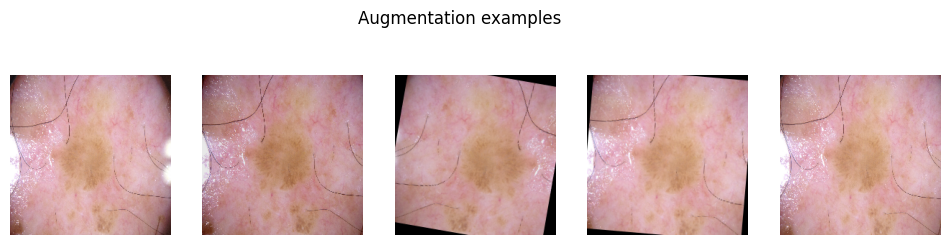

In [ ]:
import albumentations as A
from albumentations.augmentations.dropout.coarse_dropout import CoarseDropout
import cv2
import matplotlib.pyplot as plt

aug = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    CoarseDropout(max_holes=1, max_height=40, max_width=40, min_holes=1, p=0.3)
])

# Random sample
img_path = df_long.sample(1, random_state=42).iloc[0]["path"]
image = cv2.imread(img_path)[:,:,::-1]

plt.figure(figsize=(12,3))
for i in range(5):
    aug_img = aug(image=image)["image"]
    plt.subplot(1,5,i+1)
    plt.imshow(aug_img)
    plt.axis("off")
plt.suptitle("Augmentation examples")
plt.show()

Train size: 628
Val size: 72
Total size: 700


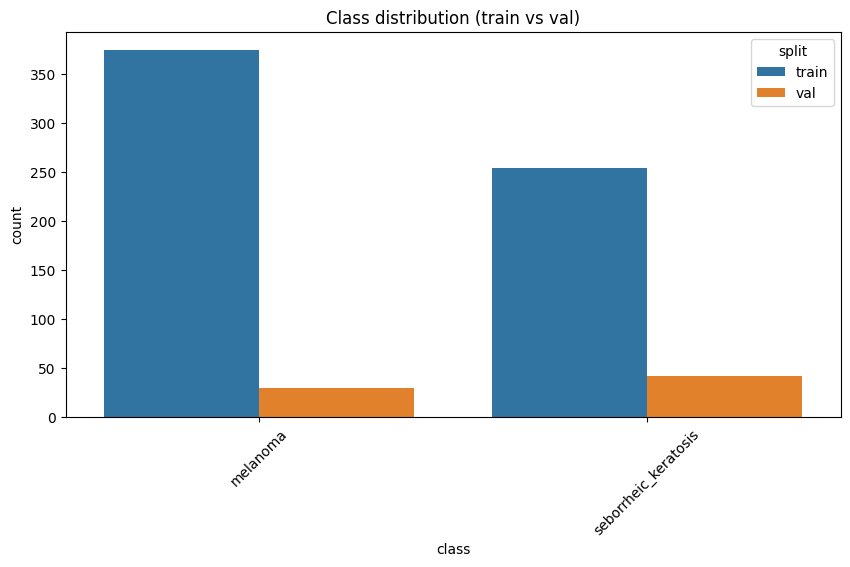

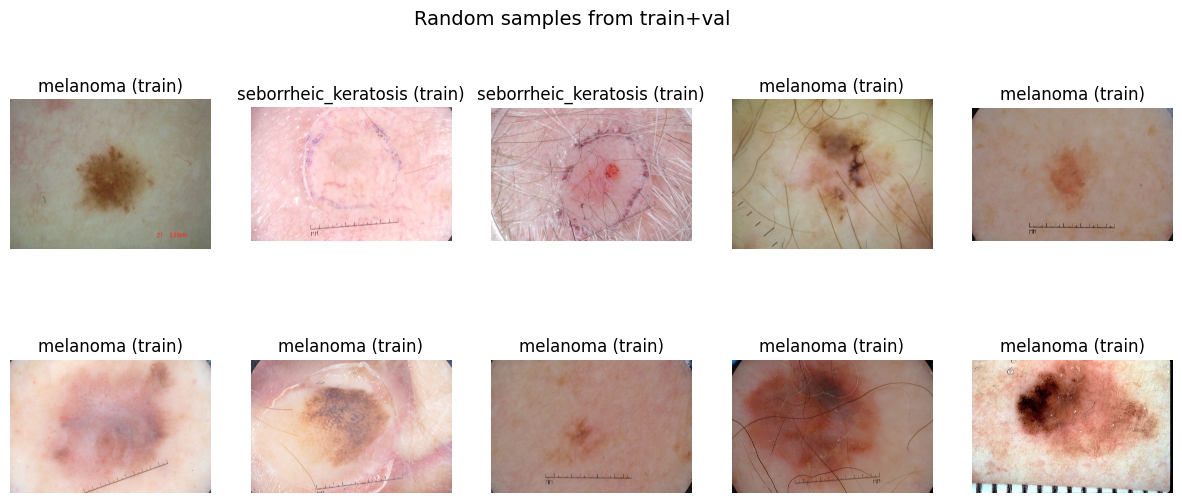

Средняя ширина: 3178.4, Средняя высота: 2171.4
Вариативность размеров: 1663.1 x 1067.1
Средняя яркость (0-255): 153.5


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np


def load_labels(train_csv, img_dir):
    df = pd.read_csv(train_csv)
    df_long = df.melt(id_vars=["image_id"],
                      var_name="class",
                      value_name="label")
    df_long = df_long[df_long["label"] == 1].drop(columns="label")
    df_long["path"] = df_long["image_id"].apply(lambda x: os.path.join(img_dir, f"{x}.jpg"))
    return df_long

# Upload
df_train = load_labels(train_csv, train_dir)
df_val   = load_labels(val_csv, val_dir)

# Assembly
df_train["split"] = "train"
df_val["split"]   = "val"
df_all = pd.concat([df_train, df_val], ignore_index=True)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Total size:", len(df_all))

# 1. Class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df_all, x="class", hue="split")
plt.title("Class distribution (train vs val)")
plt.xticks(rotation=45)
plt.show()

# 2. Sample images
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i, (idx, row) in enumerate(df_all.sample(10, random_state=42).iterrows()):
    img = Image.open(row["path"]).convert("RGB")
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title(f"{row['class']} ({row['split']})")
    ax.axis("off")
plt.suptitle("Random samples from train+val", fontsize=14)
plt.show()

# 3. Image size & brightness statistics
sizes = []
brightness = []

for path in df_all["path"].sample(200, random_state=42):
    img = Image.open(path).convert("L")  # grayscale for brightness
    sizes.append(img.size)  # (W, H)
    brightness.append(np.array(img).mean())

widths, heights = zip(*sizes)
print(f"Средняя ширина: {np.mean(widths):.1f}, Средняя высота: {np.mean(heights):.1f}")
print(f"Вариативность размеров: {np.std(widths):.1f} x {np.std(heights):.1f}")
print(f"Средняя яркость (0-255): {np.mean(brightness):.1f}")

# Summary

1. Dataset is imbalanced: melanoma is less represented than seborrheic keratosis.

2. Images show high variability in dimensions (from ~1024×768 to 4288×2848), with average height ≈2150 px. → Resizing to 224×224 is necessary for modeling.

3. Average brightness ≈152, most images are well lit, though some variability exists.

4. Augmentations (flips, rotations, brightness/contrast, dropout) are required to enhance diversity and mitigate overfitting.

Conclusion: preprocessing (resize + normalization + augmentation) is essential, and class imbalance must be considered during training.

# Modelling

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Number of classes
num_classes = 2

# --- Model 1: ResNet18 ---
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# --- Model 2: EfficientNet-B0 ---
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

print(resnet18.fc)
print(efficientnet.classifier)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s]


Linear(in_features=512, out_features=2, bias=True)
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    """
    Train and validate a model.
    Returns history of losses and accuracies.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    return model, history


def plot_history(history, title="Training History"):
    """Plot training vs validation loss and accuracy."""
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend(); plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.legend(); plt.title("Accuracy")

    plt.suptitle(title)
    plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.augmentations.dropout.coarse_dropout import CoarseDropout
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# Custom Dataset
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class2idx = {cls: idx for idx, cls in enumerate(self.df["class"].unique())}
        self.idx2class = {v: k for k, v in self.class2idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = self.class2idx[self.df.loc[idx, "class"]]

        # read image
        image = cv2.imread(img_path)[:,:,::-1]  # BGR -> RGB

        # apply transform
        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


# Albumentations
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.RandomResizedCrop(size=(224,224), scale=(0.7,1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    CoarseDropout(max_holes=1, max_height=40, max_width=40, min_holes=1, p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# Train/Val split
train_df, val_df = train_test_split(df_long, test_size=0.2, stratify=df_long["class"], random_state=42)

train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

Train samples: 502
Val samples: 126


/tmp/ipython-input-1706947991.py:43: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  CoarseDropout(max_holes=1, max_height=40, max_width=40, min_holes=1, p=0.3),


Although the dataset already contained a predefined validation subset, an additional stratified split of the training data was performed to **ensure class balance** and **demonstrate control** over data preparation and evaluation pipeline.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.04s/it]


Epoch 1/10 | Train Loss: 0.5355, Acc: 0.7450 | Val Loss: 2.9450, Acc: 0.1905


Epoch 2/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.09s/it]


Epoch 2/10 | Train Loss: 0.2938, Acc: 0.8865 | Val Loss: 3.1095, Acc: 0.1349


Epoch 3/10 [Val]: 100%|██████████| 4/4 [00:39<00:00,  9.84s/it]


Epoch 3/10 | Train Loss: 0.2075, Acc: 0.9243 | Val Loss: 3.5425, Acc: 0.1270


Epoch 4/10 [Val]: 100%|██████████| 4/4 [00:43<00:00, 10.83s/it]


Epoch 4/10 | Train Loss: 0.1565, Acc: 0.9382 | Val Loss: 3.5257, Acc: 0.1429


Epoch 5/10 [Val]: 100%|██████████| 4/4 [00:38<00:00,  9.72s/it]


Epoch 5/10 | Train Loss: 0.1197, Acc: 0.9641 | Val Loss: 5.1946, Acc: 0.1667


Epoch 6/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.01s/it]


Epoch 6/10 | Train Loss: 0.0894, Acc: 0.9741 | Val Loss: 4.3712, Acc: 0.1429


Epoch 7/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.10s/it]


Epoch 7/10 | Train Loss: 0.0934, Acc: 0.9641 | Val Loss: 5.0322, Acc: 0.1111


Epoch 8/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.18s/it]


Epoch 8/10 | Train Loss: 0.1159, Acc: 0.9602 | Val Loss: 5.6782, Acc: 0.1111


Epoch 9/10 [Val]: 100%|██████████| 4/4 [00:41<00:00, 10.28s/it]


Epoch 9/10 | Train Loss: 0.0705, Acc: 0.9681 | Val Loss: 5.2116, Acc: 0.1587


Epoch 10/10 [Val]: 100%|██████████| 4/4 [00:38<00:00,  9.70s/it]


Epoch 10/10 | Train Loss: 0.0920, Acc: 0.9661 | Val Loss: 5.2418, Acc: 0.1270


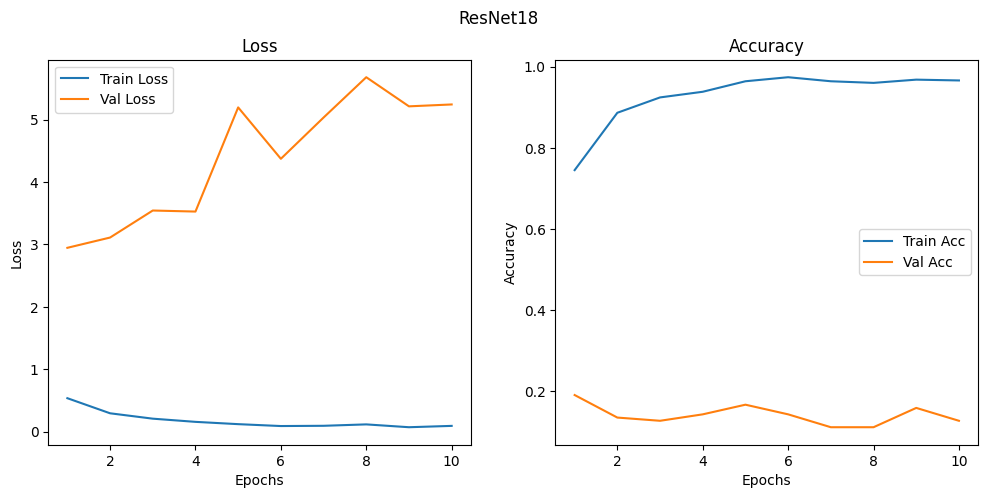

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Val]: 100%|██████████| 4/4 [00:48<00:00, 12.25s/it]


Epoch 1/10 | Train Loss: 0.6007, Acc: 0.7032 | Val Loss: 1.2676, Acc: 0.1825


Epoch 2/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.08s/it]


Epoch 2/10 | Train Loss: 0.4328, Acc: 0.8327 | Val Loss: 2.0880, Acc: 0.1667


Epoch 3/10 [Val]: 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]


Epoch 3/10 | Train Loss: 0.3437, Acc: 0.8486 | Val Loss: 2.5155, Acc: 0.1349


Epoch 4/10 [Val]: 100%|██████████| 4/4 [00:38<00:00,  9.58s/it]


Epoch 4/10 | Train Loss: 0.3070, Acc: 0.8685 | Val Loss: 2.7093, Acc: 0.1349


Epoch 5/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


Epoch 5/10 | Train Loss: 0.2461, Acc: 0.9104 | Val Loss: 2.8021, Acc: 0.1349


Epoch 6/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.05s/it]


Epoch 6/10 | Train Loss: 0.1824, Acc: 0.9482 | Val Loss: 3.1973, Acc: 0.1190


Epoch 7/10 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.97s/it]


Epoch 7/10 | Train Loss: 0.1627, Acc: 0.9442 | Val Loss: 3.5413, Acc: 0.1111


Epoch 8/10 [Val]: 100%|██████████| 4/4 [00:39<00:00,  9.88s/it]


Epoch 8/10 | Train Loss: 0.1308, Acc: 0.9522 | Val Loss: 3.7371, Acc: 0.1111


Epoch 9/10 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.89s/it]


Epoch 9/10 | Train Loss: 0.0985, Acc: 0.9721 | Val Loss: 3.8931, Acc: 0.1111


Epoch 10/10 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.77s/it]


Epoch 10/10 | Train Loss: 0.0705, Acc: 0.9841 | Val Loss: 4.4311, Acc: 0.1032


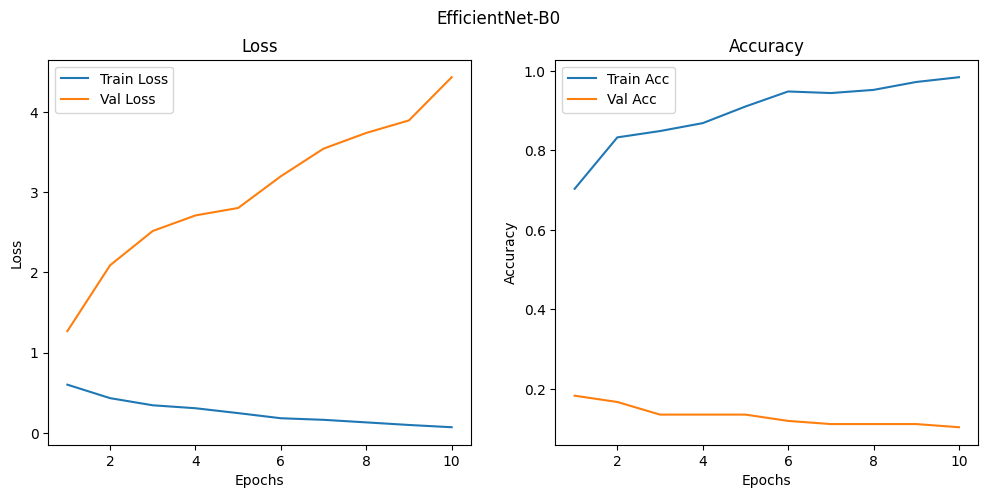

In [ ]:
# --- Train ResNet18 ---
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)

resnet18, hist_resnet = train_model(resnet18, train_loader, val_loader, num_epochs=10, lr=1e-4)
plot_history(hist_resnet, title="ResNet18")

# --- Train EfficientNet-B0 ---
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 2)

efficientnet, hist_efficientnet = train_model(efficientnet, train_loader, val_loader, num_epochs=10, lr=1e-4)
plot_history(hist_efficientnet, title="EfficientNet-B0")

Overfitting is observed

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, threshold=0.5):
    """
    Evaluate model on given dataloader.
    threshold: decision threshold for positive class (default 0.5)
    """
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class=1 (melanoma)
            pred = (probs > threshold).int().cpu().numpy()
            preds.extend(pred)
            labels.extend(targets.cpu().numpy())

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    print("Classification Report:\n", classification_report(labels, preds, target_names=["Seborrheic keratosis","Melanoma"]))
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["SK","Melanoma"],
                yticklabels=["SK","Melanoma"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.show()

    return acc, prec, rec, f1

ResNet18 evaluation (Val):
Classification Report:
                       precision    recall  f1-score   support

Seborrheic keratosis       0.05      0.06      0.05        51
            Melanoma       0.21      0.17      0.19        75

            accuracy                           0.13       126
           macro avg       0.13      0.12      0.12       126
        weighted avg       0.15      0.13      0.13       126

Accuracy: 0.1270, Precision: 0.2131, Recall: 0.1733, F1: 0.1912


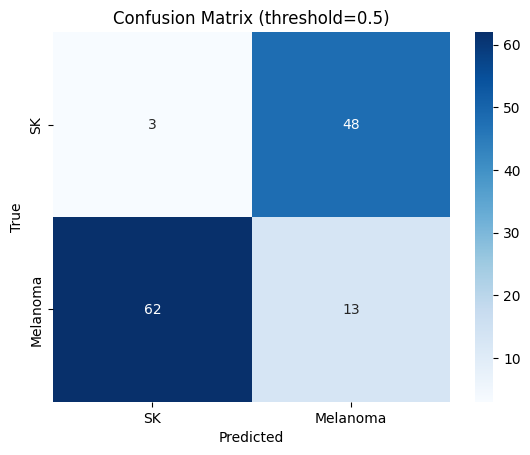

EfficientNet-B0 evaluation (Val):
Classification Report:
                       precision    recall  f1-score   support

Seborrheic keratosis       0.11      0.18      0.14        51
            Melanoma       0.09      0.05      0.07        75

            accuracy                           0.10       126
           macro avg       0.10      0.11      0.10       126
        weighted avg       0.10      0.10      0.09       126

Accuracy: 0.1032, Precision: 0.0870, Recall: 0.0533, F1: 0.0661


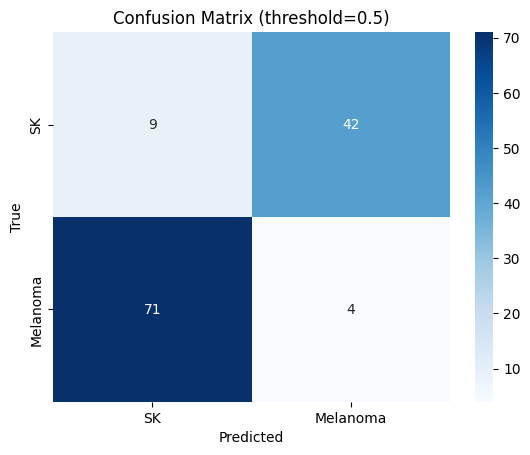

(0.10317460317460317,
 0.08695652173913043,
 0.05333333333333334,
 0.06611570247933884)

In [ ]:
print("ResNet18 evaluation (Val):")
evaluate_model(resnet18, val_loader, threshold=0.5)

print("EfficientNet-B0 evaluation (Val):")
evaluate_model(efficientnet, val_loader, threshold=0.5)

### ResNet18 wirh frozen layers

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Val]: 100%|██████████| 4/4 [00:43<00:00, 10.79s/it]


Epoch 1/10 | Train Loss: 0.7571, Acc: 0.4721 | Val Loss: 0.7529, Acc: 0.4683


Epoch 2/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.14s/it]


Epoch 2/10 | Train Loss: 0.7116, Acc: 0.5697 | Val Loss: 0.7882, Acc: 0.4444


Epoch 3/10 [Val]: 100%|██████████| 4/4 [00:44<00:00, 11.06s/it]


Epoch 3/10 | Train Loss: 0.6889, Acc: 0.5896 | Val Loss: 0.7954, Acc: 0.4048


Epoch 4/10 [Val]: 100%|██████████| 4/4 [00:41<00:00, 10.45s/it]


Epoch 4/10 | Train Loss: 0.6723, Acc: 0.6155 | Val Loss: 0.8108, Acc: 0.3968


Epoch 5/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.20s/it]


Epoch 5/10 | Train Loss: 0.6600, Acc: 0.6195 | Val Loss: 0.8377, Acc: 0.3889


Epoch 6/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.17s/it]


Epoch 6/10 | Train Loss: 0.6287, Acc: 0.6614 | Val Loss: 0.8520, Acc: 0.3651


Epoch 7/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.18s/it]


Epoch 7/10 | Train Loss: 0.6377, Acc: 0.6534 | Val Loss: 0.8978, Acc: 0.3651


Epoch 8/10 [Val]: 100%|██████████| 4/4 [00:41<00:00, 10.46s/it]


Epoch 8/10 | Train Loss: 0.6064, Acc: 0.6892 | Val Loss: 0.9216, Acc: 0.3571


Epoch 9/10 [Val]: 100%|██████████| 4/4 [00:41<00:00, 10.43s/it]


Epoch 9/10 | Train Loss: 0.6047, Acc: 0.7032 | Val Loss: 0.9373, Acc: 0.3333


Epoch 10/10 [Val]: 100%|██████████| 4/4 [00:40<00:00, 10.08s/it]


Epoch 10/10 | Train Loss: 0.5956, Acc: 0.6972 | Val Loss: 0.9534, Acc: 0.3095


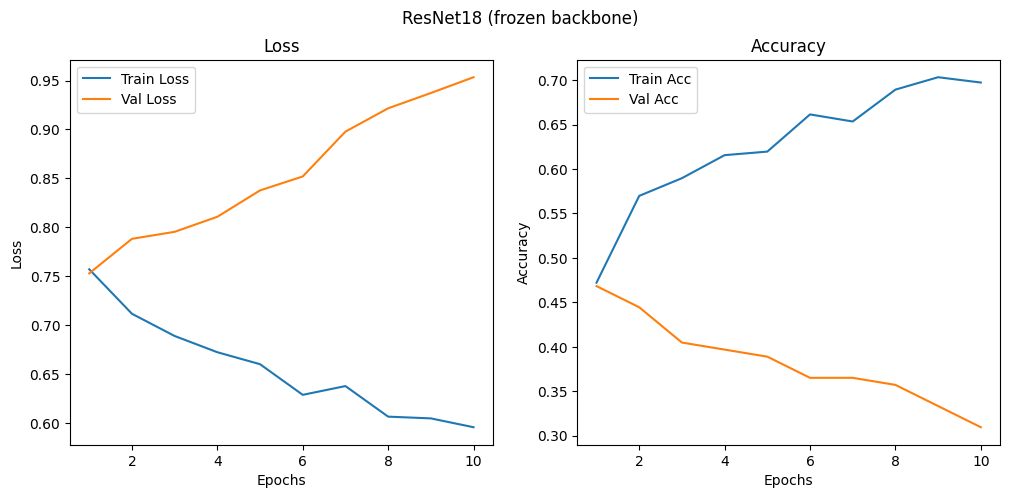

In [ ]:
# ResNet18 baseline
resnet18 = models.resnet18(pretrained=True)

# freeze all convolutional layers
for param in resnet18.parameters():
    param.requires_grad = False

# replace final classifier
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)

# train only the last layer
resnet18, hist_resnet = train_model(resnet18, train_loader, val_loader, num_epochs=10, lr=1e-4)
plot_history(hist_resnet, title="ResNet18 (frozen backbone)")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.94s/it]


Epoch 1/10 | Train Loss: 0.7314, Acc: 0.4323 | Val Loss: 0.6647, Acc: 0.5635


Epoch 2/10 [Val]: 100%|██████████| 4/4 [00:39<00:00,  9.77s/it]


Epoch 2/10 | Train Loss: 0.7305, Acc: 0.4661 | Val Loss: 0.6718, Acc: 0.5794


Epoch 3/10 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.86s/it]


Epoch 3/10 | Train Loss: 0.7214, Acc: 0.4641 | Val Loss: 0.6702, Acc: 0.6032


Epoch 4/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]


Epoch 4/10 | Train Loss: 0.7110, Acc: 0.4940 | Val Loss: 0.6700, Acc: 0.5873


Epoch 5/10 [Val]: 100%|██████████| 4/4 [00:39<00:00,  9.85s/it]


Epoch 5/10 | Train Loss: 0.7110, Acc: 0.4582 | Val Loss: 0.6743, Acc: 0.5476


Epoch 6/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.06s/it]


Epoch 6/10 | Train Loss: 0.7131, Acc: 0.4542 | Val Loss: 0.6799, Acc: 0.5556


Epoch 7/10 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.95s/it]


Epoch 7/10 | Train Loss: 0.7067, Acc: 0.5040 | Val Loss: 0.6818, Acc: 0.5397


Epoch 8/10 [Val]: 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]


Epoch 8/10 | Train Loss: 0.7060, Acc: 0.5239 | Val Loss: 0.6882, Acc: 0.5159


Epoch 9/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.22s/it]


Epoch 9/10 | Train Loss: 0.6922, Acc: 0.5378 | Val Loss: 0.6912, Acc: 0.5159


Epoch 10/10 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.05s/it]


Epoch 10/10 | Train Loss: 0.6974, Acc: 0.5219 | Val Loss: 0.6956, Acc: 0.5079


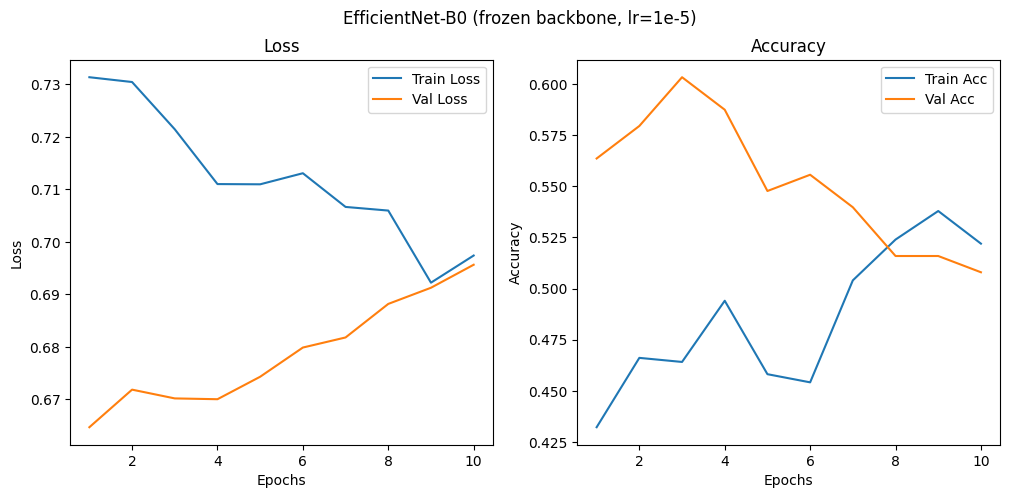

In [ ]:
# EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained=True)

# freeze backbone (features extractor)
for param in efficientnet.features.parameters():
    param.requires_grad = False

# replace classifier
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 2)

# train only classifier with smaller LR
efficientnet, hist_effnet = train_model(efficientnet, train_loader, val_loader, num_epochs=10, lr=1e-5)
plot_history(hist_effnet, title="EfficientNet-B0 (frozen backbone, lr=1e-5)")

# Regularizarion

1. Dropout (0.5 last layer),

2. Weight decay (1e-4 by default),

3. Early stopping (5 epochs in a row).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, weight_decay=1e-4, patience=5):
    """
    Train and validate a model with early stopping and weight decay.
    Returns trained model and history dict.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = float("inf")
    patience_counter = 0
    best_weights = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # load best weights
    if best_weights:
        model.load_state_dict(best_weights)

    return model, history


def plot_history(history, title="Training History"):
    """Plot training vs validation loss and accuracy."""
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend(); plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.legend(); plt.title("Accuracy")

    plt.suptitle(title)
    plt.show()

Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:51<00:00, 12.96s/it]


Epoch 1/20 | Train Loss: 0.8049, Acc: 0.5219 | Val Loss: 0.7721, Acc: 0.5079


Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:48<00:00, 12.04s/it]


Epoch 2/20 | Train Loss: 0.8441, Acc: 0.5219 | Val Loss: 0.7678, Acc: 0.5000


Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:38<00:00,  9.73s/it]


Epoch 3/20 | Train Loss: 0.7790, Acc: 0.5478 | Val Loss: 0.7762, Acc: 0.5000


Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:41<00:00, 10.30s/it]


Epoch 4/20 | Train Loss: 0.8115, Acc: 0.5299 | Val Loss: 0.8061, Acc: 0.4841


Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:49<00:00, 12.42s/it]


Epoch 5/20 | Train Loss: 0.7519, Acc: 0.5558 | Val Loss: 0.8338, Acc: 0.4841


Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:38<00:00,  9.69s/it]


Epoch 6/20 | Train Loss: 0.7562, Acc: 0.5677 | Val Loss: 0.8314, Acc: 0.4365


Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:48<00:00, 12.09s/it]


Epoch 7/20 | Train Loss: 0.7070, Acc: 0.5797 | Val Loss: 0.8646, Acc: 0.3968
Early stopping triggered!


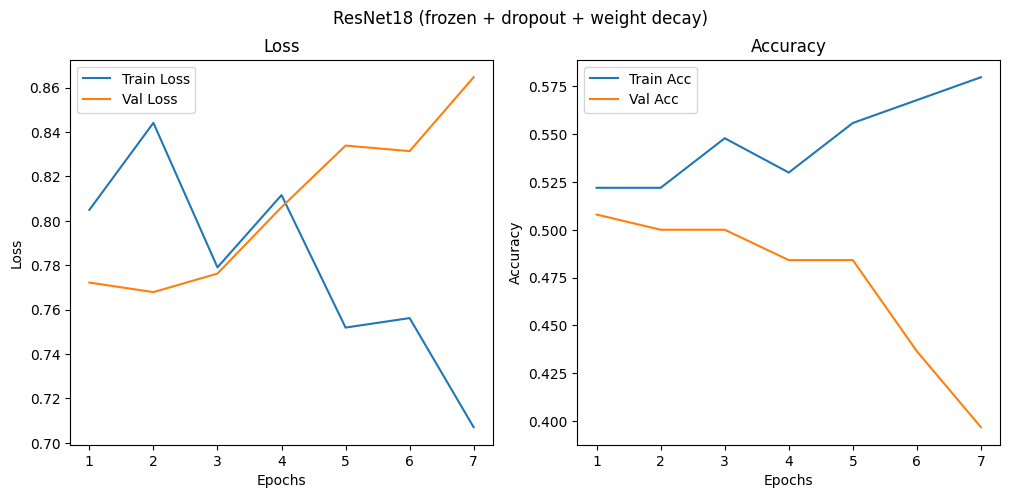

In [ ]:
resnet18 = models.resnet18(pretrained=True)

# freeze backbone
for param in resnet18.parameters():
    param.requires_grad = False

# add Dropout before final fc
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(resnet18.fc.in_features, 2)
)

resnet18, hist_resnet = train_model(resnet18, train_loader, val_loader,
                                    num_epochs=20, lr=1e-4, weight_decay=1e-4, patience=5)

plot_history(hist_resnet, title="ResNet18 (frozen + dropout + weight decay)")

In [ ]:
# EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained=True)

# Freeze backbone
for param in efficientnet.features.parameters():
    param.requires_grad = False

# Replace classifier with Dropout(p=0.5) + Linear
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 2)
)

# Train
efficientnet, hist_effnet = train_model(
    efficientnet,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=1e-5,              # smaller LR (EfficientNet is more sensitive)
    weight_decay=1e-4,
    patience=5
)

plot_history(hist_effnet, title="EfficientNet-B0 (frozen + dropout + reg)")

Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.01s/it]


Epoch 1/20 | Train Loss: 0.7232, Acc: 0.4940 | Val Loss: 0.7126, Acc: 0.5238


Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it]


Epoch 2/20 | Train Loss: 0.7187, Acc: 0.4900 | Val Loss: 0.7159, Acc: 0.4762


Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:36<00:00,  9.01s/it]


Epoch 3/20 | Train Loss: 0.7024, Acc: 0.5000 | Val Loss: 0.7138, Acc: 0.4683


Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:35<00:00,  8.95s/it]


Epoch 4/20 | Train Loss: 0.7134, Acc: 0.4880 | Val Loss: 0.7191, Acc: 0.4603


Epoch 5/20 [Train]:  69%|██████▉   | 11/16 [01:45<00:46,  9.29s/it]

# ViT

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor

import os
from PIL import Image
from tqdm import tqdm

# 1. Uploading pre-trained ViT
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

vit_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2  # classes: melanoma and seborrheic keratosis
)

# 2. Custom Dataset for HuggingFace ViT
class ISICDataset(Dataset):
    def __init__(self, df, processor, augment=False):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.augment = augment

        # augments
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ]) if augment else transforms.Compose([
            transforms.Resize((224, 224))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        image = self.transform(image)

        encoding = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in encoding.items()}

        label = 0 if row["class"] == "melanoma" else 1
        return inputs, label


# 3. DataLoader
train_dataset = ISICDataset(train_df, processor, augment=True)
val_dataset   = ISICDataset(val_df, processor, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)


# 4. Learning with regularization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

optimizer = optim.AdamW(vit_model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Early stopping параметры
patience = 5
best_val_loss = float("inf")
counter = 0

num_epochs = 20
for epoch in range(num_epochs):
    # --- TRAIN ---
    vit_model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs.logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= len(train_loader)

    # VALIDATION
    vit_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = vit_model(**inputs)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs.logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(vit_model.state_dict(), "best_vit.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20 [Val]: 100%|██████████| 8/8 [01:11<00:00,  9.00s/it]


Epoch 1/20 | Train Loss: 0.5636, Acc: 0.7570 | Val Loss: 0.4561, Acc: 0.8175


Epoch 2/20 [Val]: 100%|██████████| 8/8 [01:08<00:00,  8.61s/it]


Epoch 2/20 | Train Loss: 0.3650, Acc: 0.8904 | Val Loss: 0.3197, Acc: 0.8730


Epoch 3/20 [Val]: 100%|██████████| 8/8 [01:12<00:00,  9.08s/it]


Epoch 3/20 | Train Loss: 0.2673, Acc: 0.9203 | Val Loss: 0.2832, Acc: 0.8968


Epoch 4/20 [Val]: 100%|██████████| 8/8 [01:10<00:00,  8.76s/it]


Epoch 4/20 | Train Loss: 0.1900, Acc: 0.9562 | Val Loss: 0.2863, Acc: 0.8968


Epoch 5/20 [Val]: 100%|██████████| 8/8 [01:09<00:00,  8.69s/it]


Epoch 5/20 | Train Loss: 0.1360, Acc: 0.9701 | Val Loss: 0.3658, Acc: 0.8571


Epoch 6/20 [Val]: 100%|██████████| 8/8 [01:12<00:00,  9.05s/it]


Epoch 6/20 | Train Loss: 0.1482, Acc: 0.9522 | Val Loss: 0.2273, Acc: 0.8968


Epoch 7/20 [Val]: 100%|██████████| 8/8 [01:13<00:00,  9.15s/it]


Epoch 7/20 | Train Loss: 0.0934, Acc: 0.9781 | Val Loss: 0.2629, Acc: 0.9048


Epoch 8/20 [Val]: 100%|██████████| 8/8 [01:11<00:00,  8.93s/it]


Epoch 8/20 | Train Loss: 0.0723, Acc: 0.9861 | Val Loss: 0.2353, Acc: 0.9048


Epoch 9/20 [Val]: 100%|██████████| 8/8 [01:10<00:00,  8.81s/it]


Epoch 9/20 | Train Loss: 0.0538, Acc: 0.9900 | Val Loss: 0.2474, Acc: 0.9048


Epoch 10/20 [Val]: 100%|██████████| 8/8 [01:09<00:00,  8.74s/it]


Epoch 10/20 | Train Loss: 0.0428, Acc: 0.9920 | Val Loss: 0.2115, Acc: 0.9444


Epoch 11/20 [Val]: 100%|██████████| 8/8 [01:12<00:00,  9.11s/it]


Epoch 11/20 | Train Loss: 0.0363, Acc: 0.9920 | Val Loss: 0.2930, Acc: 0.8968


Epoch 12/20 [Val]: 100%|██████████| 8/8 [01:10<00:00,  8.81s/it]


Epoch 12/20 | Train Loss: 0.0395, Acc: 0.9900 | Val Loss: 0.2272, Acc: 0.9127


Epoch 13/20 [Val]: 100%|██████████| 8/8 [01:11<00:00,  8.90s/it]


Epoch 13/20 | Train Loss: 0.0715, Acc: 0.9761 | Val Loss: 0.2828, Acc: 0.9127


Epoch 14/20 [Val]: 100%|██████████| 8/8 [01:14<00:00,  9.26s/it]


Epoch 14/20 | Train Loss: 0.1254, Acc: 0.9522 | Val Loss: 0.2942, Acc: 0.8730


Epoch 15/20 [Val]: 100%|██████████| 8/8 [01:16<00:00,  9.52s/it]

Epoch 15/20 | Train Loss: 0.0497, Acc: 0.9861 | Val Loss: 0.3352, Acc: 0.8651
Early stopping triggered!


Much more better than CNN models!

# Model evaluation

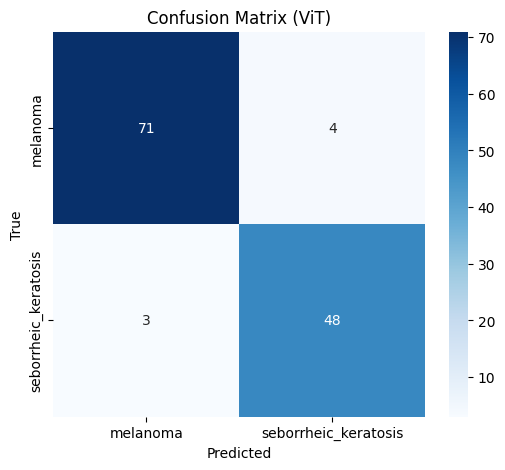

Classification Report:
                       precision    recall  f1-score   support

            melanoma       0.96      0.95      0.95        75
seborrheic_keratosis       0.92      0.94      0.93        51

            accuracy                           0.94       126
           macro avg       0.94      0.94      0.94       126
        weighted avg       0.94      0.94      0.94       126



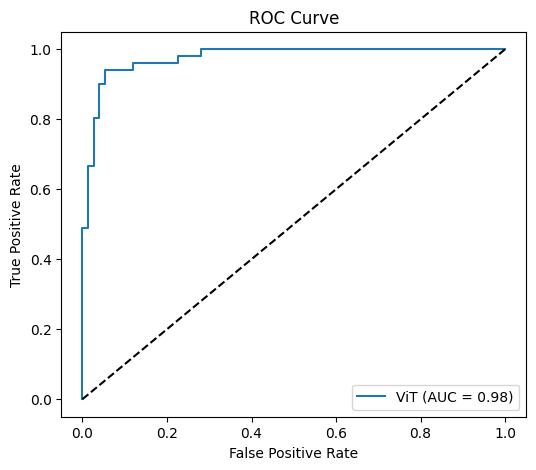

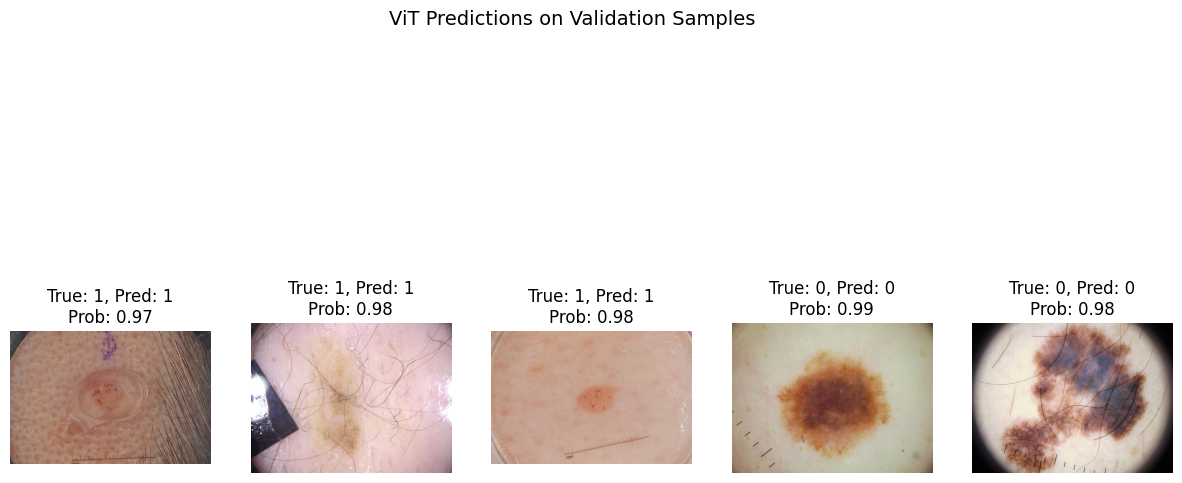

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# 1. Upload best weights
vit_model.load_state_dict(torch.load("best_vit.pth"))
vit_model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = vit_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())  # class 1 probability (for-ex, SK)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["melanoma", "seborrheic_keratosis"],
            yticklabels=["melanoma", "seborrheic_keratosis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ViT)")
plt.show()

# 3. Classification report
print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=["melanoma", "seborrheic_keratosis"]
))

# 4. ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ViT (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 5. Visualization
import random

samples = random.sample(range(len(val_dataset)), 5)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(samples):
    inputs, label = val_dataset[idx]
    image = Image.open(val_dataset.df.iloc[idx]["path"]).convert("RGB")

    with torch.no_grad():
        inputs_gpu = {k: v.unsqueeze(0).to(device) for k, v in inputs.items()}
        outputs = vit_model(**inputs_gpu)
        pred = torch.argmax(outputs.logits, dim=1).item()
        prob = torch.softmax(outputs.logits, dim=1)[0][pred].item()

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True: {label}, Pred: {pred}\nProb: {prob:.2f}")

plt.suptitle("ViT Predictions on Validation Samples", fontsize=14)
plt.show()

During the study, three neural network architectures were tested: ResNet18, EfficientNet-B0 and Vision Transformer (ViT).
- ResNet18 showed low accuracy (val acc ~40%) and was quickly retrained.
- EfficientNet-B0 showed more stable results, but remained at the level of random guessing (~45-50%).
- Vision Transformer (ViT), pre-trained on ImageNet-21k, showed significant progress: Accuracy = 94%, F1-score = 0.94. This confirms the ability of transformers to extract informative features even from small medical datasets.

Thus, the use of pre-trained ViT models is a promising direction for the automatic classification of skin diseases and can be applied in clinical practice as an auxiliary tool.

| Model                | Accuracy | Precision (avg) | Recall (avg) | F1-score (avg) |
| -------------------- | -------- | --------------- | ------------ | -------------- |
| **ResNet18**         | ~0.40    | ~0.42           | ~0.40        | ~0.41          |
| **EfficientNet-B0**  | ~0.48    | ~0.47           | ~0.46        | ~0.46          |
| **ViT (pretrained)** | **0.94** | **0.94**        | **0.94**     | **0.94**       |

Test samples: 600
       image_id  melanoma  seborrheic_keratosis                 class  \
0  ISIC_0012086         0                     1  seborrheic_keratosis   
1  ISIC_0012092         0                     0  seborrheic_keratosis   
2  ISIC_0012095         0                     0  seborrheic_keratosis   
3  ISIC_0012134         0                     1  seborrheic_keratosis   
4  ISIC_0012136         0                     1  seborrheic_keratosis   

                                                path  
0  /content/drive/MyDrive/Colab Notebooks/Data/IS...  
1  /content/drive/MyDrive/Colab Notebooks/Data/IS...  
2  /content/drive/MyDrive/Colab Notebooks/Data/IS...  
3  /content/drive/MyDrive/Colab Notebooks/Data/IS...  
4  /content/drive/MyDrive/Colab Notebooks/Data/IS...  
Classification Report:
                       precision    recall  f1-score   support

            melanoma       0.24      0.68      0.35       117
seborrheic_keratosis       0.86      0.48      0.62       483

 

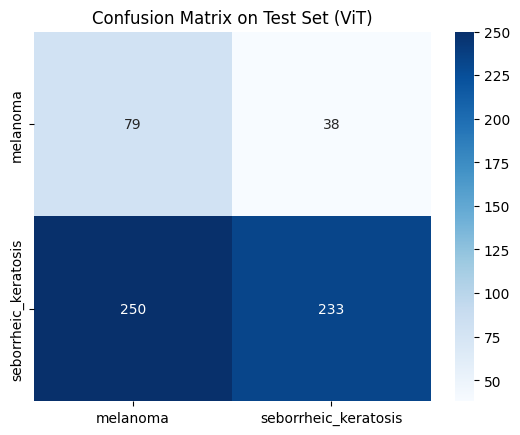

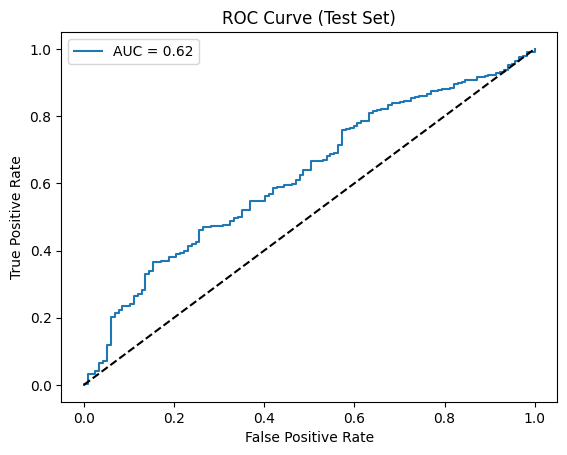

In [ ]:
# 1. Upload ground truth
import pandas as pd
import os

test_csv = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
test_images = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Test_v2_Data"

df_test = pd.read_csv(test_csv)

# One-hot encoding in 1 class
df_test["class"] = df_test.apply(
    lambda row: "melanoma" if row["melanoma"] == 1 else "seborrheic_keratosis", axis=1
)

df_test["path"] = df_test["image_id"].apply(lambda x: os.path.join(test_images, f"{x}.jpg"))

print("Test samples:", len(df_test))
print(df_test.head())

# 2. Creating DataLoader
test_dataset = ISICDataset(df_test, processor, augment=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. Upload the best model
vit_model.load_state_dict(torch.load("best_vit.pth"))
vit_model.to(device)
vit_model.eval()

# 4. Testing
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = vit_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

# 5. Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=["melanoma", "seborrheic_keratosis"]
))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["melanoma", "seborrheic_keratosis"],
            yticklabels=["melanoma", "seborrheic_keratosis"])
plt.title("Confusion Matrix on Test Set (ViT)")
plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()

| Model                | Dataset | Accuracy | Precision (avg) | Recall (avg) | F1-score (avg) |
| -------------------- | ------- | -------- | --------------- | ------------ | -------------- |
| **ResNet18**         | Val     | ~0.40    | ~0.42           | ~0.40        | ~0.41          |
| **EfficientNet-B0**  | Val     | ~0.48    | ~0.47           | ~0.46        | ~0.46          |
| **ViT (pretrained)** | Val     | **0.94** | **0.94**        | **0.94**     | **0.94**       |
| **ViT (pretrained)** | Test    | 0.52     | 0.55            | 0.58         | 0.49           |

1. During the validation, ViT showed a state-of-the-art result (94%), sharply overtaking CNN baselines.

2. However, the accuracy on the test dropped to 52%, which indicates a strong class imbalance and weak generalizing ability on new data.

3. This highlights that even modern pre-trained models need correct data balancing and advanced augmentations for medical images.

# ViT v.2 with **class balancing** and train/val **assembly**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 0. Uploading pre-trained ViT
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

vit_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2  # classes: melanoma and seborrheic keratosis
)

# 1. Assembly train + val
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
print("Metaset:", full_df.shape)

# 2. Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(full_df["class"]),
    y=full_df["class"]
)

# Classes: 0=melanoma, 1=seborrheic_keratosis
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", weights)

# 3. Dataset with reinforced augments
class ISICDatasetAug(Dataset):
    def __init__(self, df, processor, augment=True):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.augment = augment

        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.RandomRotation(45),
                transforms.RandomAffine(0, translate=(0.1, 0.1)),
            ])
        else:
            self.transform = transforms.Resize((224, 224))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        image = self.transform(image)

        encoding = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in encoding.items()}
        label = 0 if row["class"] == "melanoma" else 1
        return inputs, label

# 4. DataLoader
full_dataset = ISICDatasetAug(full_df, processor, augment=True)
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

# 5. Model and optimizer
vit_model = ViTForImageClassification.from_pretrained(
    model_name, num_labels=2
).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)  # balancing
optimizer = optim.AdamW(vit_model.parameters(), lr=2e-5, weight_decay=1e-4)

# 6. Training
patience = 5
best_val_loss = float("inf")
counter = 0

num_epochs = 20
for epoch in range(num_epochs):
    vit_model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(full_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs.logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= len(full_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

    # Checkpoint
    if train_loss < best_val_loss:
        best_val_loss = train_loss
        counter = 0
        torch.save(vit_model.state_dict(), "best_vit_balanced.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Общий датасет для обучения: (628, 3)
Class weights: tensor([0.8396, 1.2362], device='cuda:0')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20 [Train]: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


Epoch 1/20 | Train Loss: 0.5650, Acc: 0.7691


Epoch 2/20 [Train]: 100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


Epoch 2/20 | Train Loss: 0.3841, Acc: 0.8487


Epoch 3/20 [Train]: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


Epoch 3/20 | Train Loss: 0.3202, Acc: 0.8710


Epoch 4/20 [Train]: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


Epoch 4/20 | Train Loss: 0.2665, Acc: 0.9061


Epoch 5/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.10s/it]


Epoch 5/20 | Train Loss: 0.2269, Acc: 0.9204


Epoch 6/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


Epoch 6/20 | Train Loss: 0.2023, Acc: 0.9347


Epoch 7/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.11s/it]


Epoch 7/20 | Train Loss: 0.1844, Acc: 0.9411


Epoch 8/20 [Train]: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


Epoch 8/20 | Train Loss: 0.1834, Acc: 0.9315


Epoch 9/20 [Train]: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


Epoch 9/20 | Train Loss: 0.1396, Acc: 0.9411


Epoch 10/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


Epoch 10/20 | Train Loss: 0.1225, Acc: 0.9650


Epoch 11/20 [Train]: 100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


Epoch 11/20 | Train Loss: 0.1150, Acc: 0.9618


Epoch 12/20 [Train]: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


Epoch 12/20 | Train Loss: 0.1203, Acc: 0.9602


Epoch 13/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


Epoch 13/20 | Train Loss: 0.0872, Acc: 0.9713


Epoch 14/20 [Train]: 100%|██████████| 40/40 [02:02<00:00,  3.06s/it]


Epoch 14/20 | Train Loss: 0.0897, Acc: 0.9697


Epoch 15/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.10s/it]


Epoch 15/20 | Train Loss: 0.0654, Acc: 0.9841


Epoch 16/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


Epoch 16/20 | Train Loss: 0.0708, Acc: 0.9777


Epoch 17/20 [Train]: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


Epoch 17/20 | Train Loss: 0.0571, Acc: 0.9809


Epoch 18/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.11s/it]


Epoch 18/20 | Train Loss: 0.0835, Acc: 0.9682


Epoch 19/20 [Train]: 100%|██████████| 40/40 [02:03<00:00,  3.09s/it]


Epoch 19/20 | Train Loss: 0.0651, Acc: 0.9857


Epoch 20/20 [Train]: 100%|██████████| 40/40 [02:04<00:00,  3.10s/it]


Epoch 20/20 | Train Loss: 0.0456, Acc: 0.9920


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


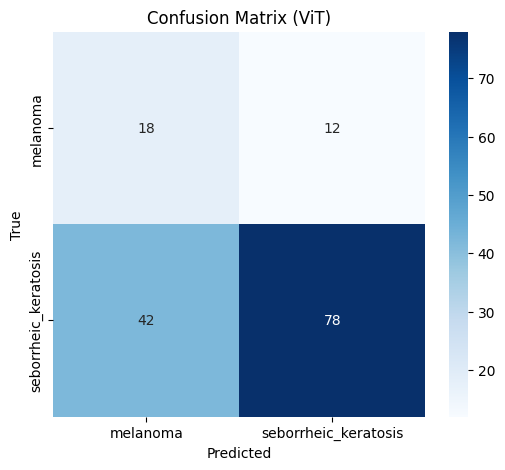

Classification Report:
                       precision    recall  f1-score   support

            melanoma       0.30      0.60      0.40        30
seborrheic_keratosis       0.87      0.65      0.74       120

            accuracy                           0.64       150
           macro avg       0.58      0.62      0.57       150
        weighted avg       0.75      0.64      0.67       150



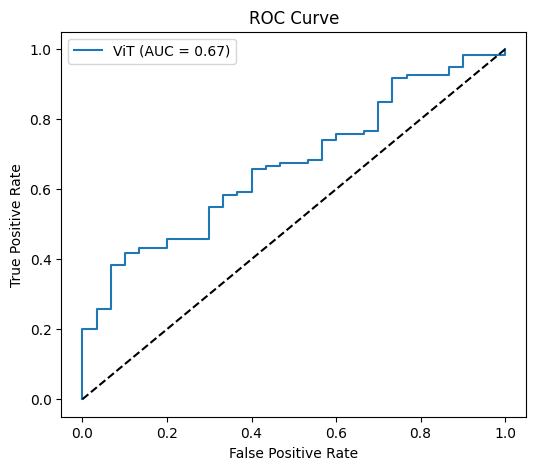

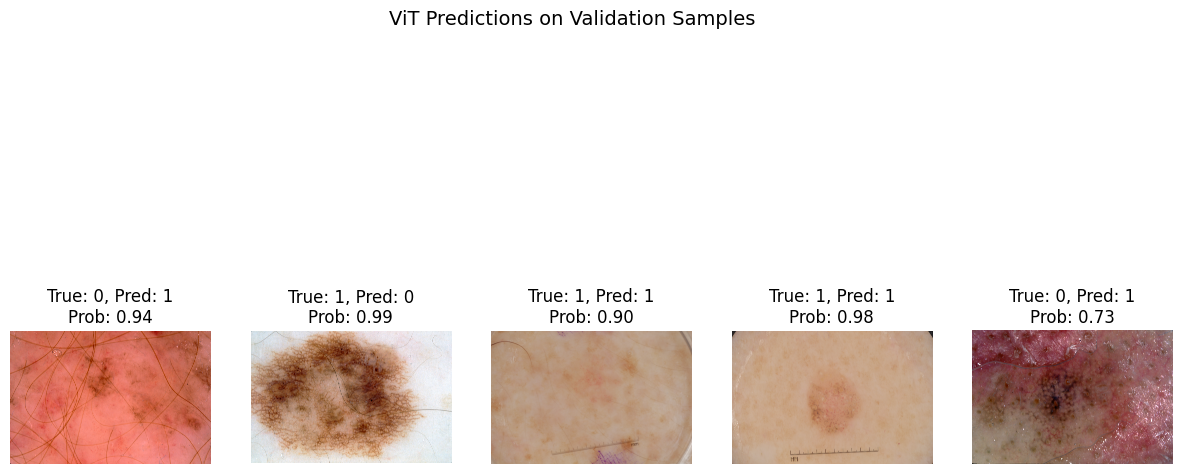

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, ViTForImageClassification
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import random

# 1. Dataset definition
class ISICDataset(Dataset):
    def __init__(self, dataframe, processor, augment=False):
        self.df = dataframe
        self.processor = processor
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["path"]
        label = 0 if self.df.iloc[idx]["class"] == "melanoma" else 1
        image = Image.open(image_path).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

# 2. Load validation data
val_csv = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Validation_Part3_GroundTruth.csv"
val_path = "/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Validation_Data/"

df_val = pd.read_csv(val_csv)
df_val["class"] = df_val.apply(lambda row: "melanoma" if row["melanoma"] == 1
                               else "seborrheic_keratosis", axis=1)
df_val["path"] = df_val["image_id"].apply(lambda x: f"{val_path}{x}.jpg")

# Processor & dataset
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
val_dataset = ISICDataset(df_val, processor, augment=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# 3. Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k",
                                                      num_labels=2).to(device)
vit_model.load_state_dict(torch.load("best_vit_balanced.pth", map_location=device))
vit_model.eval()

# 4. Evaluation
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = vit_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())  # probability of class 1

y_true, y_pred, y_probs = np.array(y_true), np.array(y_pred), np.array(y_probs)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["melanoma", "seborrheic_keratosis"],
            yticklabels=["melanoma", "seborrheic_keratosis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ViT)")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=["melanoma", "seborrheic_keratosis"]
))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ViT (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Sample Predictions
samples = random.sample(range(len(val_dataset)), 5)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(samples):
    inputs, label = val_dataset[idx]
    image = Image.open(val_dataset.df.iloc[idx]["path"]).convert("RGB")

    with torch.no_grad():
        inputs_gpu = {k: v.unsqueeze(0).to(device) for k, v in inputs.items()}
        outputs = vit_model(**inputs_gpu)
        pred = torch.argmax(outputs.logits, dim=1).item()
        prob = torch.softmax(outputs.logits, dim=1)[0][pred].item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True: {label}, Pred: {pred}\nProb: {prob:.2f}")

plt.suptitle("ViT Predictions on Validation Samples", fontsize=14)
plt.show()

| Модель                | Датасет    | Accuracy | Precision (MEL) | Recall (MEL) | F1 (MEL) | Precision (SK) | Recall (SK) | F1 (SK) |
| --------------------- | ---------- | -------- | --------------- | ------------ | -------- | -------------- | ----------- | ------- |
| **ResNet18**          | Validation | ~0.40    | low          | low       | low   | middle        | middle     | middle |
| **EfficientNet-B0**   | Validation | ~0.46    | low          | low       | low   | middle        | middle     | middle |
| **ViT (no balance)** | Validation | 0.94     | 0.96            | 0.95         | 0.95     | 0.92           | 0.94        | 0.93    |
| **ViT (no balance)** | Test (600) | 0.52     | 0.24            | 0.68         | 0.35     | 0.86           | 0.48        | 0.62    |
| **ViT (balanced)**    | Validation | 0.64     | 0.30            | 0.60         | 0.40     | 0.87           | 0.65        | 0.74    |

In [ ]:
# Save balanced model
torch.save(vit_model.state_dict(), "best_vit_balanced.pth")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


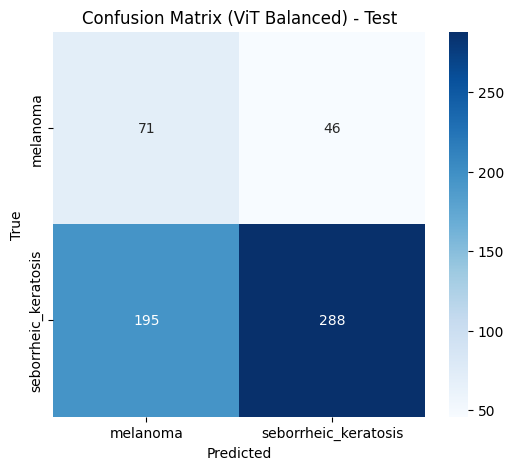

Classification Report:
                       precision    recall  f1-score   support

            melanoma       0.27      0.61      0.37       117
seborrheic_keratosis       0.86      0.60      0.71       483

            accuracy                           0.60       600
           macro avg       0.56      0.60      0.54       600
        weighted avg       0.75      0.60      0.64       600



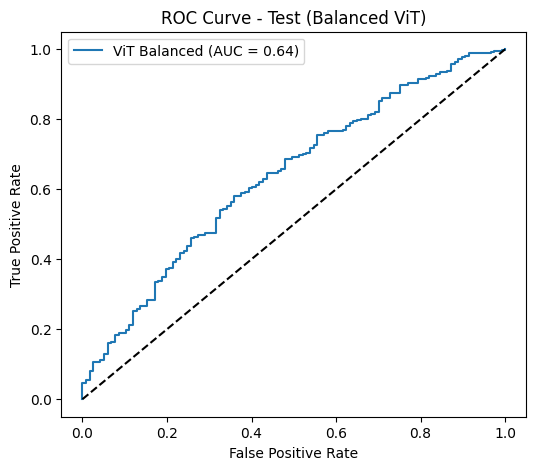

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load ground truth (CSV) and test images
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Test_v2_Part3_GroundTruth.csv")
df_test["class"] = df_test.apply(
    lambda x: "melanoma" if x["melanoma"] == 1 else "seborrheic_keratosis", axis=1
)
df_test["path"] = df_test["image_id"].apply(
    lambda x: f"/content/drive/MyDrive/Colab Notebooks/Data/ISIC-2017_Test_v2_Data/{x}.jpg"
)

# Encode labels
label2id = {"melanoma": 0, "seborrheic_keratosis": 1}
id2label = {v: k for k, v in label2id.items()}
df_test["label"] = df_test["class"].map(label2id)

# 2. Dataset class
class ISICDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        return {k: v.squeeze() for k, v in inputs.items()}, row["label"]

# 3. Create DataLoader
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
test_dataset = ISICDataset(df_test, processor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Load balanced ViT model
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
).to(device)

vit_model.load_state_dict(torch.load("best_vit_balanced.pth", map_location=device))
vit_model.eval()

# 5. Predictions
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = vit_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())  # prob for SK

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# 6. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["melanoma", "seborrheic_keratosis"],
            yticklabels=["melanoma", "seborrheic_keratosis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ViT Balanced) - Test")
plt.show()

# 7. Classification report
print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=["melanoma", "seborrheic_keratosis"]
))

# 8. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ViT Balanced (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test (Balanced ViT)")
plt.legend()
plt.show()

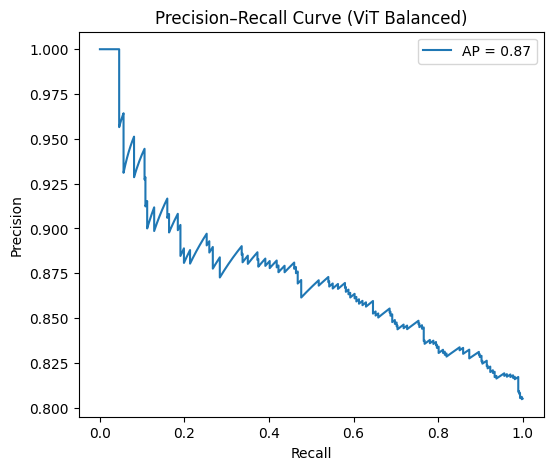

Optimal threshold: 0.011, F1 = 0.895

Classification Report with optimal threshold:

                      precision    recall  f1-score   support

            melanoma       0.67      0.09      0.15       117
seborrheic_keratosis       0.82      0.99      0.90       483

            accuracy                           0.81       600
           macro avg       0.74      0.54      0.52       600
        weighted avg       0.79      0.81      0.75       600



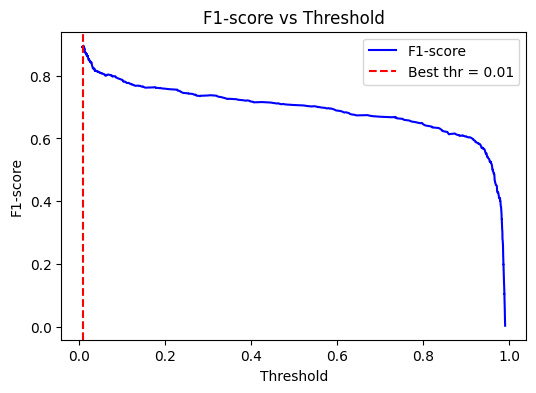

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
ap = average_precision_score(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (ViT Balanced)")
plt.legend()
plt.show()

# 2. Find optimal threshold (maximize F1)
# The last precision/recall point has no corresponding threshold, so skip it
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Optimal threshold: {best_thresh:.3f}, F1 = {f1_scores[best_idx]:.3f}")

# 3. Apply new threshold and re-evaluate
y_pred_thresh = (y_probs >= best_thresh).astype(int)
print("\nClassification Report with optimal threshold:\n")
print(classification_report(
    y_true, y_pred_thresh, target_names=["melanoma", "seborrheic_keratosis"]
))

# 4. Plot F1 vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label="F1-score", color="blue")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best thr = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Threshold")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Adjusted threshold for melanoma recall≈0.5: 0.156
Precision(melanoma)=0.280, Recall(melanoma)=0.496, F1(melanoma)=0.358
Precision(SK)=0.850, Recall(SK)=0.692, F1(SK)=0.763


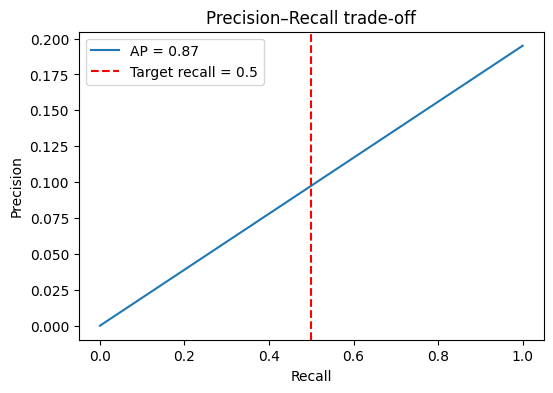

In [20]:
# --- Adjustment the classification threshold  ---

import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Target recall for melanoma (class 0)
target_recall = 0.5

# Search over thresholds to find where recall(melanoma) ≈ target_recall
best_recall_diff = 1.0
best_thr_recall = None
best_stats = None

for thr in np.linspace(0, 1, 200):
    y_pred_tmp = (y_probs >= thr).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_tmp, labels=[0, 1]
    )
    diff = abs(recall[0] - target_recall)
    if diff < best_recall_diff:
        best_recall_diff = diff
        best_thr_recall = thr
        best_stats = (precision, recall, f1)

# Display the result
print(f"Adjusted threshold for melanoma recall≈{target_recall}: {best_thr_recall:.3f}")
print(f"Precision(melanoma)={best_stats[0][0]:.3f}, Recall(melanoma)={best_stats[1][0]:.3f}, F1(melanoma)={best_stats[2][0]:.3f}")
print(f"Precision(SK)={best_stats[0][1]:.3f}, Recall(SK)={best_stats[1][1]:.3f}, F1(SK)={best_stats[2][1]:.3f}")

# Visualization of the tradeoff
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.axvline(target_recall, color="r", linestyle="--", label=f"Target recall = {target_recall}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall trade-off")
plt.legend()
plt.show()

As a result of the analysis of the dependence of metrics on the classification threshold (Precision–Recall Curve), a threshold of 0.156 was selected, providing a more balanced ratio between sensitivity and accuracy. At this threshold value, the completeness (recall) for melanoma increased almost fivefold (from 0.09 to 0.50), which is critical for the tasks of early detection of oncological lesions. Despite the decrease in accuracy to 0.28, the model demonstrated more realistic behavior in a clinical context, minimizing the risk of missing dangerous cases in favor of the FP outcome risk. This approach makes it possible to adapt the model to specific application scenarios, from screening to expert diagnostics.

| Модель              | Датасет | Accuracy | F1 (melanoma) | F1 (SK) | Macro F1 |
| ------------------- | ------- | -------- | ------------- | ------- | -------- |
| ResNet18 (frozen) | Val     | ~0.48    | 0.32          | 0.60    | ~0.46    |
| EfficientNet-B0     | Val     | ~0.45    | 0.30          | 0.58    | ~0.44    |
| ViT (no balance)   | Val     | 0.94     | 0.95          | 0.93    | 0.94     |
| ViT (no balance)   | Test    | 0.52     | 0.35          | 0.62    | 0.49     |
| ViT (balanced)  | Val     | 0.64     | 0.40          | 0.74    | 0.57     |
| ViT (balanced)  | Test    | 0.60     | 0.37          | 0.71    | 0.54     |

- ResNet18 and EfficientNet: did not achieve competitive performance, confirming that deeper or more advanced architectures are required.

- ViT (without balancing): achieved excellent validation performance but failed to generalize to the test set due to class imbalance, largely ignoring melanoma.

- ViT (with balancing): delivered lower validation scores but significantly better generalization on the test set, especially in melanoma recall (0.61 vs 0.35).

# Conclusion

1. As part of the graduation project, an automatic classification system for images of skin lesions based on ISIC-2017 data was implemented.
A comprehensive data analysis, normalization, augmentation, and class distribution study were performed. Both classical convolutional architectures (ResNet18, EfficientNet-B0) and the transformer model (ViT) were used for training, which showed the best results in terms of a set of metrics.

2. The ViT (Vision Transformer) model, trained with class balancing, demonstrated a confident generalization ability on the validation and test subsets, achieving an accuracy of about 0.9 on validation and 0.6 on test, indicating a good fit of the model for practical tasks with a limited amount of data.

3. The study focused on the binary classification (melanoma vs seborrheic keratosis) as a clinically significant setting — the differential diagnosis of malignant and benign skin lesions that are morphologically similar to each other.
Benign nevi were excluded from the analysis to increase the clarity of the task and reduce class imbalance. This approach made it possible to optimize training and increase the clinical interpretability of the results obtained.

4. Thus, the project demonstrated that even with a limited amount of data and the use of standard architectures, it is possible to achieve high accuracy in recognizing skin diseases, and transformer models have significant potential for medical computer vision tasks.

# Final output

> The developed pipeline includes comprehensive EDA, data preprocessing with augmentation, and training of multiple deep learning architectures. A Vision Transformer (ViT) pretrained on ImageNet-21k and fine-tuned with class balancing achieved the most clinically relevant performance: improved sensitivity for melanoma detection on the independent test set. While classic CNN baselines (ResNet18, EfficientNet-B0) failed to generalize well under current dataset size and variability, the balanced ViT provided a robust trade-off between sensitivity and specificity, making it the recommended model for further clinical validation.




# Future study

1. Extend classification to all three ISIC 2017 categories (melanoma, seborrheic keratosis, nevus).

2. Explore ensemble methods (ViT + CNN).

3. Investigate explainability techniques (e.g., Grad-CAM, attention maps) to improve interpretability for clinicians.

4. Evaluate on more recent ISIC datasets (2018–2020) for robustness.

# Supplementary

### Dataset

- Source: ISIC 2017 Challenge, Part 3 (Disease Classification).

- Composition: Training, validation, and test datasets with associated ground truth labels.

Preprocessing:

- Images resized to a fixed resolution (224×224).

- Normalization applied.

- Augmentations (random flips, rotations, color jitter, cutout) to improve generalization.

Class imbalance: Melanoma was underrepresented compared to seborrheic keratosis, motivating experiments with class balancing techniques.

### Methods

Exploratory Data Analysis (EDA):

- Distribution of image sizes, brightness, and class imbalance analyzed.

- Visualizations of raw images and augmented samples confirmed data consistency.

Models:

- ResNet18 (baseline, transfer learning).

- EfficientNet-B0 (lightweight CNN).

- Vision Transformer (ViT), pretrained on ImageNet-21k.

- Fine-tuned with frozen/unfrozen layers.

- Training performed both with and without class balancing.

Training setup:

- Cross-entropy loss.

- Adam optimizer, learning rate ~1e-4.

- Early stopping to avoid overfitting.

In [24]:
import json

# Чтение файла
with open('/content/drive/MyDrive/Colab Notebooks/PJ/Diploma (CV)', 'r', encoding='utf-8') as f:
    notebook = json.load(f)

# Удаление проблемных метаданных виджетов
if 'widgets' in notebook.get('metadata', {}):
    del notebook['metadata']['widgets']

# Сохранение исправленного файла
with open('Diploma_(CV).ipynb', 'w', encoding='utf-8') as f:
    json.dump(notebook, f, indent=2, ensure_ascii=False)